In [1]:
import pandas as pd
import matplotlib.pyplot as plt

acs_df = pd.read_csv("acs2017_census_tract_data.csv")
covid_df = pd.read_csv("COVID_county_data.csv")

`A.Transform the ACS data`


In [2]:
county_info = (
    acs_df.groupby(["County", "State"])
    .agg({"TotalPop": "sum", "Poverty": "mean", "IncomePerCap": "mean"})
    .reset_index()
)
county_info.insert(0, "ID", range(1, len(county_info) + 1))
county_info["Poverty"] = county_info["Poverty"].round(3)
county_info["IncomePerCap"] = county_info["IncomePerCap"].round(3)
county_info.rename(
    columns={
        "County": "Name",
        "TotalPop": "Population",
        "IncomePerCap": "PerCapitaIncome",
    },
    inplace=True,
)
county_info

,ID,Name,State,Population,Poverty,PerCapitaIncome
0,1,Abbeville County,South Carolina,24788,22.183,19402.833
1,2,Acadia Parish,Louisiana,62607,21.933,21454.250
2,3,Accomack County,Virginia,32840,20.112,24769.750
3,4,Ada County,Idaho,435117,12.608,32672.661
4,5,Adair County,Iowa,7192,9.567,28840.667
...,...,...,...,...,...,...
3215,3216,Yuma County,Arizona,204281,19.358,21479.642
3216,3217,Yuma County,Colorado,10109,14.350,24841.000
3217,3218,Zapata County,Texas,14415,32.567,17884.333
3218,3219,Zavala County,Texas,12152,41.375,12660.250


`Questions`


In [3]:
def get_deets(df, countyname, state):
    return df.loc[(df["Name"] == countyname) & (df["State"] == state)]

display(get_deets(county_info, "Loudoun County", "Virginia"))
display(get_deets(county_info, "Washington County", "Oregon"))
display(get_deets(county_info, "Harlan County", "Kentucky"))
display(get_deets(county_info, "Malheur County", "Oregon"))

max_val = county_info["Population"].max()
max_val_row = county_info[county_info["Population"] == max_val]
display(max_val_row)
min_val = county_info["Population"].min()
min_val_row = county_info[county_info["Population"] == min_val]
display(min_val_row)

,ID,Name,State,Population,Poverty,PerCapitaIncome
1759,1760,Loudoun County,Virginia,374558,3.884,50391.016


,ID,Name,State,Population,Poverty,PerCapitaIncome
3046,3047,Washington County,Oregon,572071,10.446,34970.817


,ID,Name,State,Population,Poverty,PerCapitaIncome
1234,1235,Harlan County,Kentucky,27548,33.318,16010.364


,ID,Name,State,Population,Poverty,PerCapitaIncome
1822,1823,Malheur County,Oregon,30421,24.414,17966.429


,ID,Name,State,Population,Poverty,PerCapitaIncome
1757,1758,Los Angeles County,California,10105722,17.324,31389.414


,ID,Name,State,Population,Poverty,PerCapitaIncome
1764,1765,Loving County,Texas,74,17.1,35530.0


`B.Transform the COVID Data`


In [4]:
covid_df["Month"] = pd.to_datetime(covid_df["date"]).dt.month
covid_df["Year"] = pd.to_datetime(covid_df["date"]).dt.year
covid_monthly = (
    covid_df.groupby(["Month", "Year", "state", "county"])
    .agg({"cases": sum, "deaths": sum})
    .reset_index()
)
covid_monthly["county"] = covid_monthly["county"] + " County"
covid_monthly.rename(
    columns={
        "county": "Name",
        "state": "State",
        "cases": "Cases",
        "deaths": "Deaths",
    },
    inplace=True,
)
covid_monthly = pd.merge(covid_monthly, county_info,how="left", on=["Name", "State"])
covid_monthly.drop(columns={"State", "Name", "PerCapitaIncome", "Population", "Poverty"})

,Month,Year,Cases,Deaths,ID
0,1,2020,6,0.0,1833.0
1,1,2020,6,0.0,1758.0
2,1,2020,7,0.0,2194.0
3,1,2020,1,0.0,2591.0
4,1,2020,10,0.0,652.0
...,...,...,...,...,...
37252,12,2020,78122,412.0,2814.0
37253,12,2020,59845,67.0,2850.0
37254,12,2020,41859,201.0,2917.0
37255,12,2020,20107,350.0,3024.0


`Questions`


In [5]:
def get_cases(Name, Month):
    return covid_monthly.loc[(covid_monthly["Name"] == Name) & (covid_monthly["Month"] == Month)]

display(get_cases("Malheur County", 8))
display(get_cases("Malheur County", 1))
display(get_cases("Malheur County", 2))

,Month,Year,State,Name,Cases,Deaths,ID,Population,Poverty,PerCapitaIncome
23267,8,2020,Oregon,Malheur County,28163,459.0,1823.0,30421.0,24.414,17966.429


,Month,Year,State,Name,Cases,Deaths,ID,Population,Poverty,PerCapitaIncome
2257,1,2021,Oregon,Malheur County,96297,1627.0,1823.0,30421.0,24.414,17966.429


,Month,Year,State,Name,Cases,Deaths,ID,Population,Poverty,PerCapitaIncome
5526,2,2021,Oregon,Malheur County,62620,1079.0,1823.0,30421.0,24.414,17966.429


`C.Integrate COVID Data with ACS Data`


In [6]:
covid_summary = (covid_monthly.groupby("ID").agg({"Cases": "sum", "Deaths": "sum"}).reset_index())
covid_summary.rename(columns={"Cases": "TotalCases", "Deaths": "TotalDeaths"}, inplace=True)
covid_summary = pd.merge(covid_summary, county_info, how="left", on="ID")
covid_summary["TotalCasesPer100K"] = round((covid_summary["TotalCases"]) / (covid_summary["Population"] / 100000), 2)
covid_summary["TotalDeathsPer100K"] = round((covid_summary["TotalDeaths"]) / (covid_summary["Population"] / 100000), 2)
display(covid_summary)

,ID,TotalCases,TotalDeaths,Name,State,Population,Poverty,PerCapitaIncome,TotalCasesPer100K,TotalDeathsPer100K
0,1.0,204553,3900.0,Abbeville County,South Carolina,24788,22.183,19402.833,825209.78,15733.42
1,3.0,387085,5723.0,Accomack County,Virginia,32840,20.112,24769.750,1178699.76,17426.92
2,4.0,5230256,50724.0,Ada County,Idaho,435117,12.608,32672.661,1202034.40,11657.55
3,5.0,70396,1792.0,Adair County,Iowa,7192,9.567,28840.667,978809.79,24916.57
4,6.0,178833,8026.0,Adair County,Kentucky,19304,22.329,18252.286,926403.85,41576.88
...,...,...,...,...,...,...,...,...,...,...
2997,3216.0,4445946,96197.0,Yuma County,Arizona,204281,19.358,21479.642,2176387.43,47090.53
2998,3217.0,68447,1016.0,Yuma County,Colorado,10109,14.350,24841.000,677089.72,10050.45
2999,3218.0,137919,2007.0,Zapata County,Texas,14415,32.567,17884.333,956774.19,13923.00
3000,3219.0,151910,4176.0,Zavala County,Texas,12152,41.375,12660.250,1250082.29,34364.71


`Questions`


In [7]:
display(get_deets(covid_summary, "Washington County", "Oregon"))
display(get_deets(covid_summary, "Malheur County", "Oregon"))
display(get_deets(covid_summary, "Loudoun County", "Virginia"))
display(get_deets(covid_summary, "Harlan County", "Kentucky"))

,ID,TotalCases,TotalDeaths,Name,State,Population,Poverty,PerCapitaIncome,TotalCasesPer100K,TotalDeathsPer100K
2842,3047.0,2136473,22246.0,Washington County,Oregon,572071,10.446,34970.817,373462.91,3888.68


,ID,TotalCases,TotalDeaths,Name,State,Population,Poverty,PerCapitaIncome,TotalCasesPer100K,TotalDeathsPer100K
1703,1823.0,450303,7712.0,Malheur County,Oregon,30421,24.414,17966.429,1480237.34,25350.91


,ID,TotalCases,TotalDeaths,Name,State,Population,Poverty,PerCapitaIncome,TotalCasesPer100K,TotalDeathsPer100K
1644,1760.0,2473893,35621.0,Loudoun County,Virginia,374558,3.884,50391.016,660483.29,9510.14


,ID,TotalCases,TotalDeaths,Name,State,Population,Poverty,PerCapitaIncome,TotalCasesPer100K,TotalDeathsPer100K
1151,1235.0,205984,3994.0,Harlan County,Kentucky,27548,33.318,16010.364,747727.6,14498.33


`D.Analysis`


The correlation between COVID total cases vs. % population in poverty in OR is -0.16686069160626282
The correlation between COVID total deaths vs. % population in poverty in OR is -0.11875200116227456
The correlation between COVID total cases vs. Per Capita Income level in OR is 0.5479086767948086
The correlation between COVID total deaths vs. Per Capita Income level in OR is 0.5015766803400471
The correlation between COVID total cases vs. % population in poverty across USA is -0.015448128241335552
The correlation between COVID total deaths vs. % population in poverty across USA is -0.021094251952463162
The correlation between COVID total cases vs. Per Capita Income level across USA is 0.19194331711374943
The correlation between COVID total deaths vs. Per Capita Income level across USA is 0.22201016764140577
The correlation between COVID total cases vs. Total Population across USA is 0.9661167179574903
The correlation between COVID total deaths vs. Total Population across USA is 0.8828

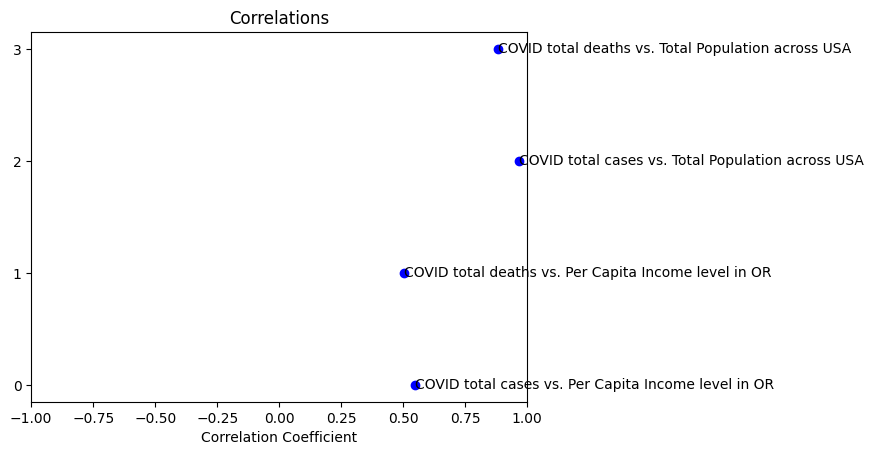

In [8]:
or_county = covid_summary[covid_summary["State"] == "Oregon"]


def getR():
    R1 = or_county["TotalCases"].corr(or_county["Poverty"])
    R2 = or_county["TotalDeaths"].corr(or_county["Poverty"])
    R3 = or_county["TotalCases"].corr(or_county["PerCapitaIncome"])
    R4 = or_county["TotalDeaths"].corr(or_county["PerCapitaIncome"])
    R5 = covid_summary["TotalCases"].corr(covid_summary["Poverty"])
    R6 = covid_summary["TotalDeaths"].corr(covid_summary["Poverty"])
    R7 = covid_summary["TotalCases"].corr(covid_summary["PerCapitaIncome"])
    R8 = covid_summary["TotalDeaths"].corr(covid_summary["PerCapitaIncome"])
    R9 = covid_summary["TotalCases"].corr(covid_summary["Population"])
    R10 = covid_summary["TotalDeaths"].corr(covid_summary["Population"])
    return {
        "COVID total cases vs. % population in poverty in OR": R1,
        "COVID total deaths vs. % population in poverty in OR": R2,
        "COVID total cases vs. Per Capita Income level in OR": R3,
        "COVID total deaths vs. Per Capita Income level in OR": R4,
        "COVID total cases vs. % population in poverty across USA": R5,
        "COVID total deaths vs. % population in poverty across USA": R6,
        "COVID total cases vs. Per Capita Income level across USA": R7,
        "COVID total deaths vs. Per Capita Income level across USA": R8,
        "COVID total cases vs. Total Population across USA": R9,
        "COVID total deaths vs. Total Population across USA": R10,
        }
results = getR()
for r, correlation in results.items():
    print(f"The correlation between {r} is {correlation}")
    filtered_results = {
        r: correlation for r, correlation in results.items() if abs(correlation) > 0.5
    }
fig, ax = plt.subplots()
ax.set_xlim(-1, 1)
y_values = range(len(filtered_results))
ax.scatter(filtered_results.values(), y_values, color="Blue")
for y, (r, correlation) in zip(y_values, filtered_results.items()):
    ax.text(correlation, y, r, ha="left", va="center")
ax.set_title("Correlations")
ax.set_xlabel("Correlation Coefficient")
ax.set_yticks(y_values)
# ax.set_yticklabels(filtered_results.keys())
plt.show()